In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames: 
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bitcoin/Bitcoin.csv


In [10]:
!pip install arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 903.7/903.7 kB 7.4 MB/s eta 0:00:0000:0100:01


In [149]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from arch import arch_model
from sklearn.metrics import mean_absolute_error
import plotly.express as px

##### Overall view of the dataset
##### Changing the time column to a datetime data type

In [17]:
data = pd.read_csv("/kaggle/input/bitcoin/Bitcoin.csv",
                  parse_dates=["time"])
print("data shape:", data.shape)
print(data.info())
data.head()

data shape: (1601, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1601 entries, 0 to 1600
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        1601 non-null   datetime64[ns]
 1   high        1601 non-null   float64       
 2   low         1601 non-null   float64       
 3   open        1601 non-null   float64       
 4   volumefrom  1601 non-null   float64       
 5   volumeto    1601 non-null   float64       
 6   close       1601 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 87.7 KB
None


,time,high,low,open,volumefrom,volumeto,close
0,2017-04-14,1602.00,1555.51,1576.75,290.19,458549.04,1556.22
1,2017-04-15,1589.98,1555.00,1556.22,147.81,233499.17,1588.99
2,2017-04-16,1589.99,1559.00,1588.99,249.72,393138.79,1579.52
3,2017-04-17,1619.99,1559.99,1579.52,275.75,440720.31,1602.00
4,2017-04-18,1629.97,1575.00,1602.00,493.52,791768.10,1619.83


##### Rename the time column and set it as the DataFrame's Index

In [18]:
data.rename(columns={"time":"Date"}, inplace=True)
data=data.set_index("Date")
data.head(5)

,high,low,open,volumefrom,volumeto,close
Date,,,,,,
2017-04-14,1602.00,1555.51,1576.75,290.19,458549.04,1556.22
2017-04-15,1589.98,1555.00,1556.22,147.81,233499.17,1588.99
2017-04-16,1589.99,1559.00,1588.99,249.72,393138.79,1579.52
2017-04-17,1619.99,1559.99,1579.52,275.75,440720.31,1602.00
2017-04-18,1629.97,1575.00,1602.00,493.52,791768.10,1619.83


##### Below we can confirm that the Bitcoin prices are non stationary

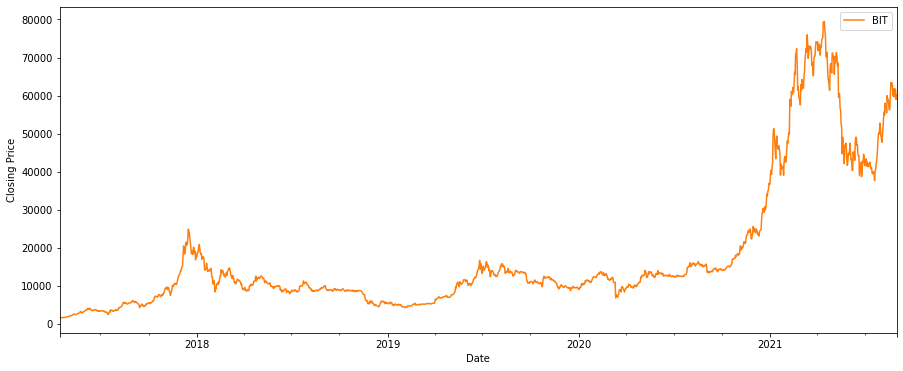

In [19]:
fig, ax = plt.subplots(figsize=(15,6))
data["close"].plot(ax=ax, label= "BIT", color= "C1")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.legend();

##### Calculating the daily returns

In [23]:
returns_data= data["close"].pct_change()*100
print(returns_data.head(5))

Date
2017-04-14         NaN
2017-04-15    2.105743
2017-04-16   -0.595976
2017-04-17    1.423217
2017-04-18    1.112984
Name: close, dtype: float64


##### Visualizing the Time series plot of the returns, we can see that the returns are stationary in that they oscillate about the mean of zero. Moreover volatility clustering is potrayed.


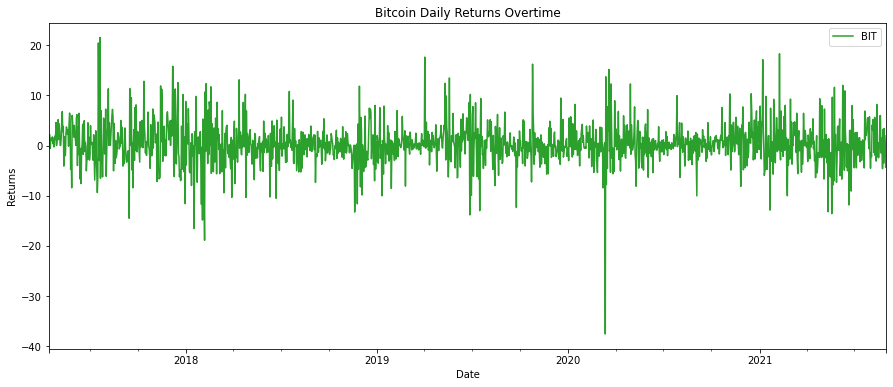

In [26]:
fig, ax = plt.subplots(figsize=(15,6))
returns_data.plot(ax=ax, label= "BIT", color= "C2")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.title("Bitcoin Daily Returns Overtime")
plt.legend();


##### From the figure below we can see that the distribution of the returns series is Leptokurtic; has a very sharp high peak and heavy tails. This indicates a kurtosis of greater than 3 implying a higher level of risk for the asset.

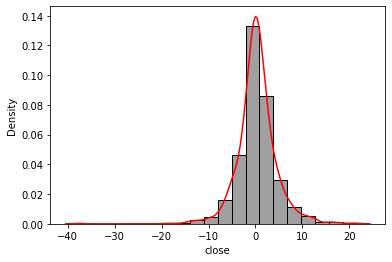

In [46]:
sns.histplot(returns_data, bins=20, stat="density", fill=True, color="gray")
sns.kdeplot(returns_data, color="r");


##### Calculating daily and annual volatility, assuming there are 365 trading days in a calendar year for the Bitcoin.

In [56]:
returns_data_daily_vol = returns_data.std()
returns_annual_daily_vol = returns_data_daily_vol * np.sqrt(365)
print("Bitcoin: ", "{:.2f}%\n)".format(returns_data_daily_vol))
print("Bitcoin: ", "{:.2f}%\n)".format(returns_annual_daily_vol))

Bitcoin:  4.16%
)
Bitcoin:  79.49%
)


##### Rolling Volatility/ Moving Average using a 50 day window
##### We want to see how volatility changes across time

<AxesSubplot:xlabel='Date', ylabel='Returns'>

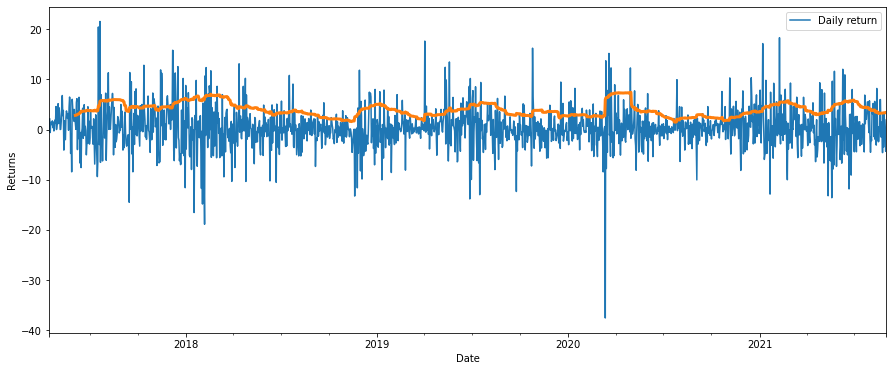

In [61]:
returns_rolling_50day= returns_data.rolling(window=50).std().dropna()
fig, ax = plt.subplots(figsize=(15,6))
returns_data.plot(ax=ax, label= "Daily return")
plt.xlabel("Date")
plt.ylabel("Returns")
plt.legend();

returns_rolling_50day.plot(ax=ax, label="50 days rolling", linewidth=3)

##### Horrizontal splitting/ Cutoff split. Splitting the data into 80% for the training set 

In [90]:
returns_data

Date
2017-04-14         NaN
2017-04-15    2.105743
2017-04-16   -0.595976
2017-04-17    1.423217
2017-04-18    1.112984
                ...   
2021-08-27    3.394892
2021-08-28    0.074562
2021-08-29   -0.082866
2021-08-30   -4.322434
2021-08-31    1.919178
Name: close, Length: 1601, dtype: float64

In [91]:
data=returns_data.dropna()
data

Date
2017-04-15    2.105743
2017-04-16   -0.595976
2017-04-17    1.423217
2017-04-18    1.112984
2017-04-19    0.982202
                ...   
2021-08-27    3.394892
2021-08-28    0.074562
2021-08-29   -0.082866
2021-08-30   -4.322434
2021-08-31    1.919178
Name: close, Length: 1600, dtype: float64

In [100]:
cutoff = int(len(data*0.8))
y_train = data.iloc[:cutoff]

##### Building the Volatiliy model (Garch(1,1))
##### p= alpha term, q= beta term

In [101]:
model= arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -4477.28
Distribution:                  Normal   AIC:                           8962.56
Method:            Maximum Likelihood   BIC:                           8984.07
                                        No. Observations:                 1600
Date:                Mon, Jan 16 2023   Df Residuals:                     1599
Time:                        19:55:12   Df Model:                            1
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.3447  9.186e-02      3.753  1.750e-04 [  0.165,  0.525]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.9474      0.479      1.979  4.777e-02 [9.317e-03,  1.885]
alpha[1]       0.0771  2.724e-02      2.832  4.629e-03 [2.375e-02,  0.131]
beta[1]        0.8713  4.073e-02     21.391 1.608e-101   [  0.791,  0.951]
==========================================================================

Covariance estimator: robust
"""

##### Evaluation of the Time series model using Walk Forward Validation on the Test data

In [102]:
# Create empty list to hold predictions
predictions = []

#Calculate size of the test data(20%)
test_size = int(len(data)*0.2)

#Walk Forward Validation
for i in range(test_size):
    #Create test data
    y_train = data.iloc[: -(test_size - i)]
    #Train  model
    model = arch_model(y_train, p=1, q=1, rescale=False).fit(disp=0)
    #Generate next prediction(volatility)
    next_pred = model.forecast(horizon=1, reindex=False).variance.iloc[0,0] ** 0.5
    #Append prediction to list
    predictions.append(next_pred)
#Create series from predictions list
y_test_wfv = pd.Series(predictions, index= data.tail(test_size).index)

print("y_test_wfv type:", type(y_test_wfv))
print("y_test_wfv shape:", y_test_wfv.shape)
y_test_wfv.head()


y_test_wfv type: <class 'pandas.core.series.Series'>
y_test_wfv shape: (320,)


Date
2020-10-16    2.788144
2020-10-17    2.843042
2020-10-18    2.808946
2020-10-19    2.808529
2020-10-20    2.842275
dtype: float64

In [120]:
test_data= data.tail(test_size)
test_data

Date
2020-10-16   -1.692003
2020-10-17    0.116593
2020-10-18    1.478007
2020-10-19    2.056756
2020-10-20    1.019818
                ...   
2021-08-27    3.394892
2021-08-28    0.074562
2021-08-29   -0.082866
2021-08-30   -4.322434
2021-08-31    1.919178
Name: close, Length: 320, dtype: float64

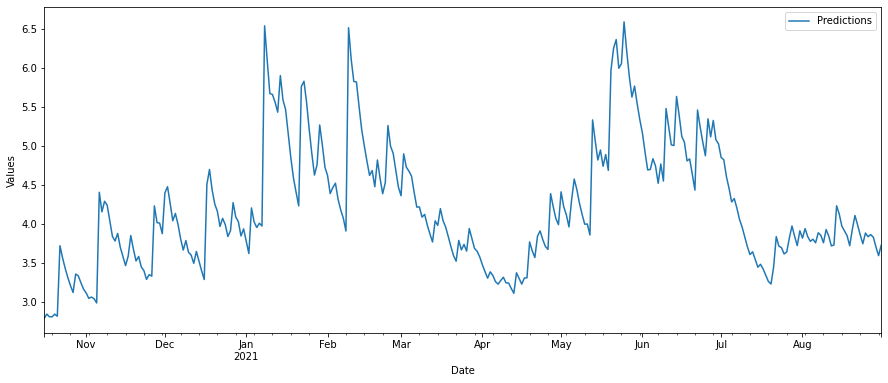

In [156]:
fig, ax = plt.subplots(figsize=(15,6))
y_test_wfv.plot(ax=ax, label= "Predictions")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend();